In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import numpy as np

from SES_setup import *
from utils import *
from style import *

SES_setup loaded globally


In [119]:
def rate_to_state(init_rho, final_rho, L):
    rho_dot = qt.vector_to_operator(L*qt.operator_to_vector(init_rho))
    return (rho_dot*final_rho).tr()

def rate_to_manifold(init_rho, L, ops, manifold='OO'):
    if manifold == 'ground':
        manifold = 'OO'
    rho_dot = qt.vector_to_operator(L*qt.operator_to_vector(init_rho))
    return (rho_dot*ops[manifold]).tr()




# Displacements
Defining everything via the IBM hamiltonian and taking into account the normalisation of the displacement operator gives the right answers for this known test case. However, with RC mapping parameters and spectral densities taken from the [J. Chem. Phys paper](https://aip.scitation.org/doi/10.1063/1.4940218) and the Liouvillians defined in my code/notes, which agree with Redfield without any hacky prefactors, it appears like $\alpha_{ph}$ is missing a factor of 4 (or $\kappa$ is missing a factor of 2). This gives a factor of 2 error in the displacment of the modes. I think my approach now will be to include a factor of $1/2$ in the definition of the displacement, so that the re. I'll fully resolve this issue later on.

In [12]:
80/ev_to_inv_cm

0.00991878990763127

In [30]:
# Code for calculating decay rates from DS/BS to GS (manifold and total)



def exciton_to_ground(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5):
    # Currently predicts a product state for the initial condition
    T_EM =0.
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
    couplings = np.linspace(0.1,50,30)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'wc':[], 'nonadd':[], 'add': []}
    data_dict = {key: {'dtg': copy.deepcopy(in_in_dict), 
                       'btg': copy.deepcopy(in_in_dict)} for key in data_names}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=N)
            
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            H_wc, L_ns, L_s = get_H_and_L_wc(PARAMS['H_sub'], PARAMS, shift=False)
            #print_PARAMS(PARAMS)
            #ss = steadystate(H[1], [L_add])
            ops = make_expectation_operators(PARAMS)
            x = position_ops(PARAMS)
            energies, states = exciton_states(PARAMS, shift=False)
            dark, bright = states[0]*states[0].dag(), states[1]*states[1].dag()
            #init_test = 0.5*(XO_proj+OX_proj)
            r0 = displaced_initial(dark, PARAMS, silent=True) # Initial state is displaced
            assert abs(np.sum((dark - ENR_ptrace(r0, 0, PARAMS['exc'])).full())) <1e-6
            l = "{}".format(int(w_0))
            
            data_dict[l]['dtg']['nonadd'].append(rate_to_manifold(r0, L['nonadd'], ops, manifold='OO'))
            data_dict[l]['dtg']['add'].append(rate_to_manifold(r0, L['add'], ops, manifold='OO'))
            #data_dict[l]['dtg']['wc'].append(rate_to_manifold(r0, L_ns, ops, manifold='OO'))
            
            r0 = displaced_initial(bright, PARAMS, silent=True) # Initial state is displaced
            data_dict[l]['btg']['nonadd'].append(rate_to_manifold(r0, L['nonadd'], ops, manifold='OO'))
            data_dict[l]['btg']['add'].append(rate_to_manifold(r0, L['add'], ops, manifold='OO'))
            #data_dict[l]['btg']['wc'].append(rate_to_ground(bright, L_ns))
            # rate from bright to dark
            #data_dict[l]['btd']['nonadd'].append(rate_to_dark(r0, L, dark))
            #data_dict[l]['btd']['add'].append(rate_to_dark(r0, L_add, dark))
            #data_dict[l]['btd']['wc'].append(rate_to_dark(bright, L_ns, dark))
            i+=1
            if i%10 == 0:
                print (i)
    print("Calculation complete")
    return data_dict, couplings

In [22]:
def plot_decay_rates(data_dict, couplings):
    for w0, dat in data_dict.items(): # for each w0, unpack data which is dictionary with keys [btd, dtg, btg]
        # for each set of rates, plot a new figure
        
        
        displacements = [c/float(w0) for c in couplings] 
        for rate_type, rate_data in dat.items(): # for each set of rates, plot each
            plt.figure()
            plt.title(rate_type +' '+ w0)
            for label, data_set in rate_data.items():
                if (rate_type != 'btd') and (label == 'wc'):
                    data_set = np.array(data_set)
                if (label != 'wc'):
                    plt.plot(displacements, data_set, label=label)
            plt.legend()

10
20
30
Calculation complete


ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

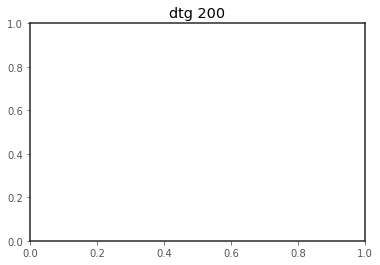

In [6]:
data_dict_77, couplings = exciton_to_ground(0, 150., 150., 77, N=6)
plot_decay_rates(data_dict_77, couplings)

[]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[1.0136220836707008, 1.013376369809669, 1.0131306560526567, 1.0128849424674746, 1.0126392291645114, 1.012393516288966, 1.0121478040287581, 1.0119020926124234, 1.0116563823339206, 1.0114106735353194, 1.0111649666382967, 1.0109192621410799, 1.0106735606122719, 1.0104278627146703, 1.010182169210866, 1.0099364809632039, 1.0096907989467245, 1.009445124255633, 1.0091994581075627, 1.0089538018580972, 1.008708157006498, 1.008462525190948, 1.0082169082178003, 1.0079713080477086, 1.0077257268188582, 1.007480166848881, 1.0072346306430495, 1.0069891208919688, 1.0067436405018209, 1.0064981925757062]
[1.0136363636358738, 1.0136363636296153, 1.0136363636309602, 1.0136363636276298, 1.013636363626701

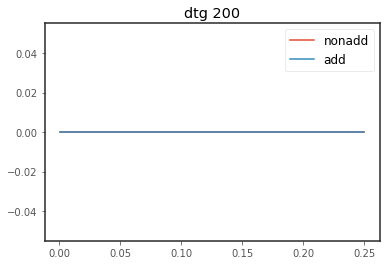

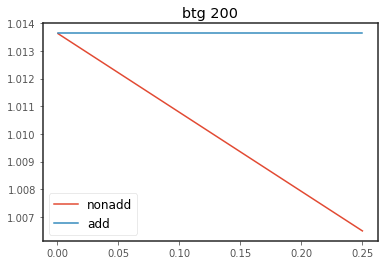

In [23]:
plot_decay_rates(data_dict_77, couplings)

10
20
30
Calculation complete
[]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[1.013622961491404, 1.0133929336092942, 1.0131640158848003, 1.0129362246092526, 1.0127095761142222, 1.0124840867768952, 1.0122597730084304, 1.0120366512486798, 1.0118147379675433, 1.011594049654128, 1.0113746028166986, 1.0111564139777525, 1.0109394996657568, 1.0107238764170985, 1.0105095607691013, 1.0102965692562387, 1.01008491840609, 1.0098746247372181, 1.0096657047533524, 1.0094581749414886, 1.0092520517688308, 1.0090473516764504, 1.0088440910798364, 1.0086422863624718, 1.0084419538748535, 1.0082431099308466, 1.008045770804565, 1.0078499527251998, 1.0076556718812133, 1.0074629444057308]
[1.0136363636363643, 1.013636363636364, 1.0136363636363634, 1.0136

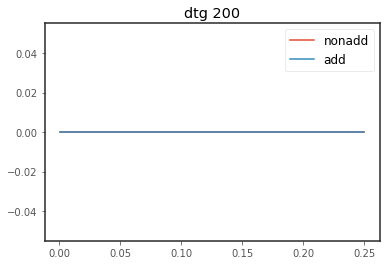

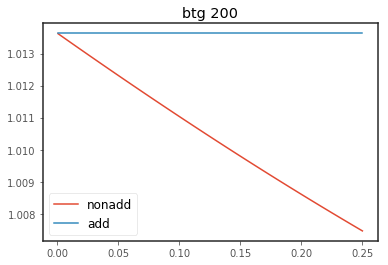

In [24]:
data_dict_300, couplings = exciton_to_ground(0, 150., 150., 300, N=6)
plot_decay_rates(data_dict_300, couplings)

It might be safe to assume that the initial product state is messing things up here - so the dark state cannot decay. On short timescales the manifold will relax to some quasi-equilibrium, from which it decays. 

In [35]:
def sort_eigs(evals, evecs):
    idx = evals.argsort()
    return evals[idx], evecs[idx]

def dark_bright_check(states, ops):
    # ensures the states have the correct symmetry properties
    dark_states = states['dark']
    bright_states = states['bright']
    ground_states = states['ground']
    i = 0
    for g in ground_states:
        assert abs((g*g.dag()*ops["OO"]).tr()-1) <1e-10
        for d in dark_states:
            assert abs((d.dag()*g).tr()) <1e-10
    for d in dark_states:
        #print((d.dag()*d).tr())
        assert abs((d.dag()*d).tr()-1) <1e-10
        for b in bright_states:
            #print ((d.dag()*b))
            assert abs((b.dag()*b).tr()-1) <1e-10
            assert abs((d.dag()*b).tr()) <1e-10
            assert abs((d.dag()*d).tr()-1) <1e-10
            i += 1

            

def separate_states(H, PARAMS, trunc=0.8):
    # truncation removes the really dodgy states for which the parity is unclear 
    # (this might not be numerical error, but it probs is)
    ops = make_expectation_operators(PARAMS)
    energies, states = H.eigenstates()
    energies, states = sort_eigs(energies, states)
    energies, states = energies[0:int(len(states)*trunc)], states[0:int(len(states)*trunc)]
    parities = [(state*state.dag()*ops['sigma_x']).tr() for state in states]
    phonon_occ_dict = {'dark': [], 'bright': [], 'ground': []}
    states_dict = {'dark': [], 'bright': [], 'ground': []}
    energies_dict = {'dark': [], 'bright': [], 'ground': []} # for checking
    for i, parity in enumerate(parities):
        occ_1 = (states[i].dag()*ops['RC1_number']*states[i]).tr().real
        occ_2 = (states[i].dag()*ops['RC2_number']*states[i]).tr().real
        if abs(parity)<1e-10:
            states_dict['ground'].append(states[i])
            energies_dict['ground'].append(energies[i])
            phonon_occ_dict['ground'].append((occ_1, occ_2))
        elif parity>1e-10:
            states_dict['bright'].append(states[i])
            energies_dict['bright'].append(energies[i])
            phonon_occ_dict['bright'].append((occ_1, occ_2))
        elif parity<-1e-10:
            states_dict['dark'].append(states[i])
            energies_dict['dark'].append(energies[i])
            phonon_occ_dict['dark'].append((occ_1, occ_2))
        else:
            raise ValueError("Parity is {} ".format(parity))
    if len(states_dict['ground'])  == len(states):
        print("This will not work for V=0. Ground contains all states.")
    #print(len(states_dict['dark']), len(states_dict['bright']), len(states_dict['ground']))
    #assert (len(states_dict['dark']) == len(states_dict['bright']))
    dark_bright_check(states_dict, ops)
    return energies_dict, states_dict, phonon_occ_dict

# Low Temperature characterisation

In the first instance, I need to understand what happens at low phonon and EMF temperature. Just choose some sensible parameters (say from monomer paper or Dominic's dimer paper) and calculate. $\omega_0 = 30meV, 60meV, 120meV$
- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=0$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$ Does increasing phonon coupling actually increase population of dark state? Is this because $\sigma_x$ gains displacement operators?
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=0$ 

Then I'll be in a position to understand EMF thermal occupation. Steadystate population is likely to be $\propto\Gamma_{g,+}/\Gamma_{-,0}$, unless dominated by phonon reorganisation.
- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=6000$

Can I then characterise population by $\Gamma_{g,+}/\Gamma_{-,0}$? In the first instance just from zero states to manifolds.

In [134]:
def lowest_eig_to_states(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., T_EM=0.,
                         N=5, start_manifold='dark', end_manifold='OO'):
    # Characterise low T_ph behaviour of decay
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
    couplings = np.linspace(0.1,50,5)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [0,0,1,2,3,4,5]
    data_dict = {}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        inner_data_dict = {'s0-manifold': copy.deepcopy(in_in_dict),
                's0-f0': copy.deepcopy(in_in_dict), 
               's0-f1': copy.deepcopy(in_in_dict),
               's0-f2': copy.deepcopy(in_in_dict),
               's0-f3': copy.deepcopy(in_in_dict),
                's0-f4': copy.deepcopy(in_in_dict),
                's0-f5': copy.deepcopy(in_in_dict)}
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=N)
            print(PARAMS['T_EM'])
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
            ops = make_expectation_operators(PARAMS)
            for idx, state_label in zip(state_indexes, inner_data_dict.keys()):
                if state_label == 's0-manifold': # Can check decay to whole target manifold
                    si = states_dict[start_manifold][0]
                    ri = si*si.dag()
                    inner_data_dict[state_label]['nonadd'].append(rate_to_manifold(ri, L['nonadd'], 
                                                                             ops, manifold=end_manifold))
                    inner_data_dict[state_label]['add'].append(rate_to_manifold(ri, L['add'], 
                                                                             ops, manifold=end_manifold))
                else:
                    si = states_dict[start_manifold][0]
                    sf = states_dict[end_manifold][idx]
                    ri = si*si.dag()
                    rf = sf*sf.dag()
                    inner_data_dict[state_label]['nonadd'].append(rate_to_state(ri, rf, L['nonadd']))
                    inner_data_dict[state_label]['add'].append(rate_to_state(ri, rf, L['add']))
            i+=1
            if i%10 == 0:
                print (i)
        data_dict.update({str(int(w_0)) : inner_data_dict})
    print("Calculation complete")
    data_dict.update({'couplings' : couplings})
    return data_dict


In [121]:
def plot_manifold_rates(data_dict, title = 'dtg', show_total_decay=False):
    couplings =data_dict['couplings']
    for omega_0, data in data_dict.items():
        if omega_0 == 'couplings':
            couplings = data
        else:
            plt.figure()
            plt.title(title+ ' ' + omega_0)
            i=0
            for rate_name, rate_data in data.items():
                print (rate_name, (abs(sum(rate_data['nonadd']))))
                if( (rate_name == 's0-manifold') or (abs(sum(rate_data['nonadd'])) <1e-9)):
                    pass # we don't really want the total decay rate in there, or any that are zero
                else:
                    c = colourWheel[i]
                    plt.plot(couplings, rate_data['nonadd'], linestyle='solid', label=rate_name, c=c) 
                    plt.plot(couplings, rate_data['add'], linestyle='dashed', c=c)
                    i+=1
            plt.legend()

In [68]:
w_2 = 1.4 * ev_to_inv_cm
bias = 0 # 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 0.
T_ph = 150
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 80. #2*w0
print (eta, V/eta)

161.31 0.5


$|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=0$

In [128]:
dtg_low_T_rates = lowest_eig_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=5, T_EM=0,
                                                      start_manifold='dark', end_manifold='ground')


10
Calculation complete


s0-manifold 0.14354469377734963
s0-f0 0.0
s0-f1 0.06367014016233823
s0-f2 0.06367014016234035
s0-f3 0.0
s0-f4 0.007468594007316278
s0-f5 0.007468594007316674
s0-manifold 0.10704619686361985
s0-f0 0.0
s0-f1 0.05049341292664013
s0-f2 0.05049341292664043
s0-f3 0.0
s0-f4 0.002907585290342956
s0-f5 0.0029075852903429926
s0-manifold 0.06655675787526986
s0-f0 0.0
s0-f1 0.032373777200584083
s0-f2 0.03237377720058276
s0-f3 0.0
s0-f4 0.0008869399254281681
s0-f5 0.0008869399254281724


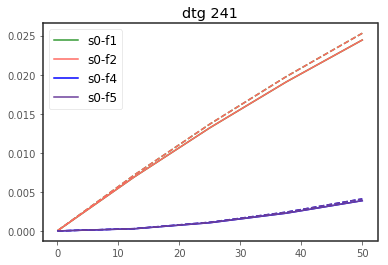

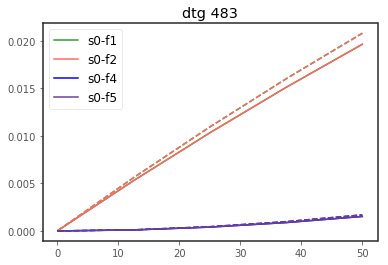

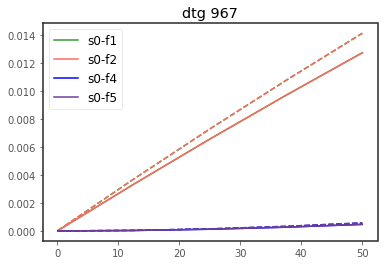

In [129]:
plot_manifold_rates(dtg_low_T_rates)

$|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$

In [122]:
btd_low_T_rates = lowest_eig_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=5, T_EM=0,
                                                      start_manifold='bright', end_manifold='dark')

10
Calculation complete


s0-manifold 1.3107927772494687e-13
s0-f0 137.53371733598135
s0-f1 0.1159200052538619
s0-f2 0.09249943578194603
s0-f3 0.002051877374752064
s0-f4 0.001181988515399236
s0-f5 0.02029417929986102
s0-manifold 8.121913136089919e-14
s0-f0 29.836097853681267
s0-f1 0.0006462507088077267
s0-f2 0.0005394203490031203
s0-f3 6.599829896259028e-07
s0-f4 2.628134247877072e-06
s0-f5 1.870481652555117e-05
s0-manifold 8.929755464672448e-14
s0-f0 6.9618932511872
s0-f1 3.954087466402301e-07
s0-f2 3.568149537749338e-07
s0-f3 3.3705468827348834e-11
s0-f4 5.4167585404693327e-11
s0-f5 2.5770115341968486e-11


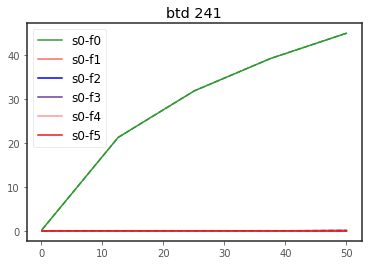

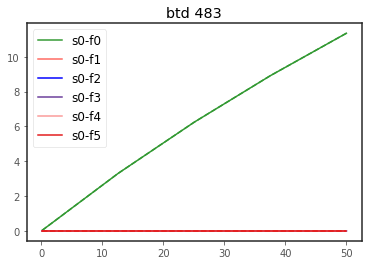

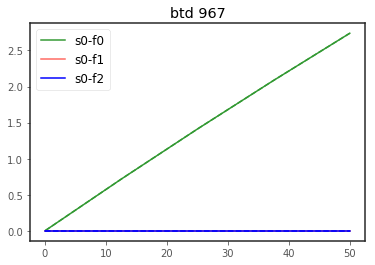

In [123]:
plot_manifold_rates(btd_low_T_rates, title='btd')

- These rates suggest that the zero phonon transition is the largest between bright and dark.
- The $|\psi_+^{0}\rangle \to |-\rangle$ rate is predicted to be zero, which doesn't make sense. I can't work out why this would be the case, unless it's do with with product state thing again.
- Strangely, increasing $\omega_0$ decreases the bright-to-dark rate. This is exactly the same in both non-additive and additive cases. 

When $\omega_0$ increases, the overlap between ground and exciton states increases due to smaller displacement. This might cause the excitonic coupling to be smaller since these terms gain

$|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=0$ 

In [125]:
btg_low_T_rates = lowest_eig_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=5, T_EM=0,
                                                      start_manifold='bright', end_manifold='ground')

10
Calculation complete


s0-manifold 3.791000298383194
s0-f0 3.4931587359571066
s0-f1 0.11461781503075764
s0-f2 0.11461781503076343
s0-f3 0.0064929704953311795
s0-f4 0.028267012199845946
s0-f5 0.028267012199844337
s0-manifold 4.646268360180487
s0-f0 4.468303016087173
s0-f1 0.08169480731485354
s0-f2 0.081694807314859
s0-f3 0.0004135191360140593
s0-f4 0.006769369885822928
s0-f5 0.006769369885823796
s0-manifold 4.886124854798924
s0-f0 4.7961903567168624
s0-f1 0.04350517142496394
s0-f2 0.04350517142496535
s0-f3 2.105118534447839e-05
s0-f4 0.0014218027506435944
s0-f5 0.0014218027506435558


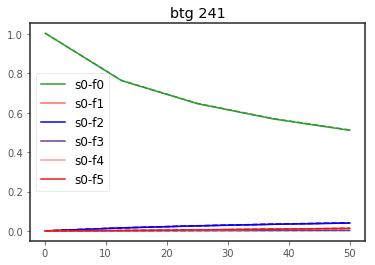

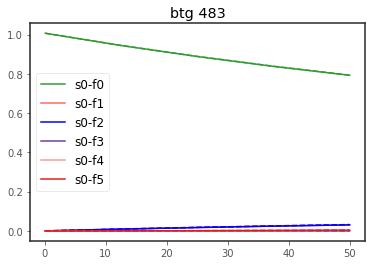

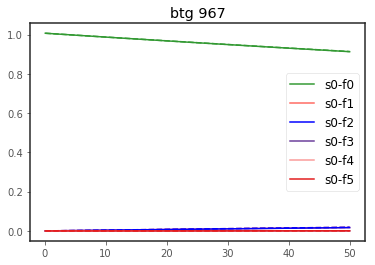

In [126]:
plot_manifold_rates(btg_low_T_rates, title='btg')

Thermal Occupation of EMF

- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=6000$

In [135]:
dtg_high_T_rates = lowest_eig_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=6, T_EM=6000,
                                                      start_manifold='dark', end_manifold='ground')
btd_high_T_rates = lowest_eig_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=6, T_EM=6000,
                                                      start_manifold='bright', end_manifold='dark')
btg_high_T_rates = lowest_eig_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=6, T_EM=6000,
                                                      start_manifold='bright', end_manifold='ground')

6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
10
6000
6000
6000
6000
6000
Calculation complete
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
10
6000
6000
6000
6000
6000
Calculation complete
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
10
6000
6000
6000
6000
6000
Calculation complete


s0-manifold 0.15480351175962245
s0-f0 0.0
s0-f1 0.06860503073465475
s0-f2 0.06860503073465932
s0-f3 0.0
s0-f4 0.008093017481452587
s0-f5 0.008093017481453016
s0-manifold 0.11595281386989668
s0-f0 0.0
s0-f1 0.05466016923663129
s0-f2 0.054660169236632514
s0-f3 0.0
s0-f4 0.003180298465144081
s0-f5 0.0031802984651442016
s0-manifold 0.07284320327360935
s0-f0 0.0
s0-f1 0.03540672686238162
s0-f2 0.03540672686237766
s0-f3 0.0
s0-f4 0.00099438209541779
s0-f5 0.0009943820954175617
s0-manifold 3.1556524742635285e-14
s0-f0 138.97411578340518
s0-f1 2.2205669549207993e-05
s0-f2 2.8310711142486364e-05
s0-f3 16.4126461997824
s0-f4 1.6917747225333123e-06
s0-f5 0.01611188914109933
s0-manifold 1.2994307280754069e-12
s0-f0 29.905247623261673
s0-f1 7.171378776033628e-09
s0-f2 6.577592872485802e-09
s0-f3 2.1892285613101665e-12
s0-f4 3.874739844277005e-10
s0-f5 1.2190739466379048e-05
s0-manifold 5.288235453817283e-13
s0-f0 6.964274427981479
s0-f1 2.658756727020582e-12
s0-f2 7.356352531653742e-12
s0-f3 4.1462

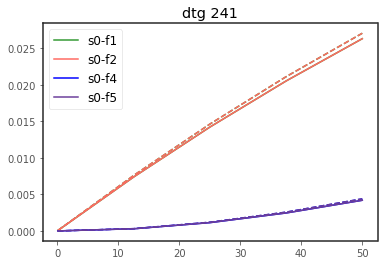

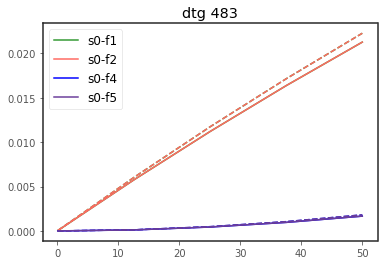

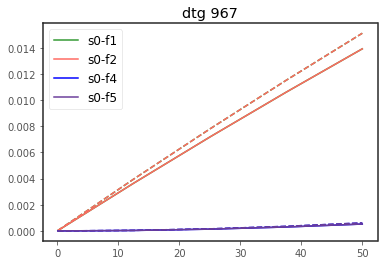

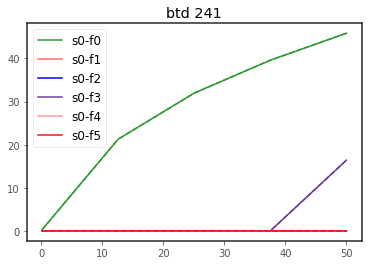

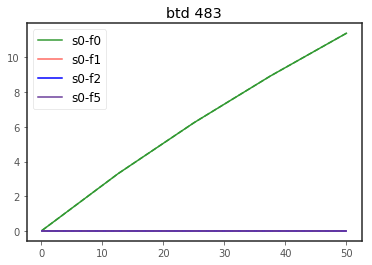

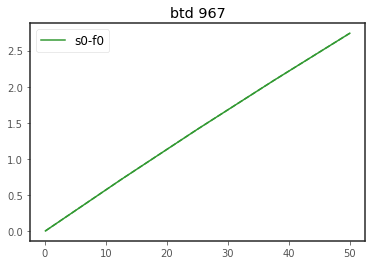

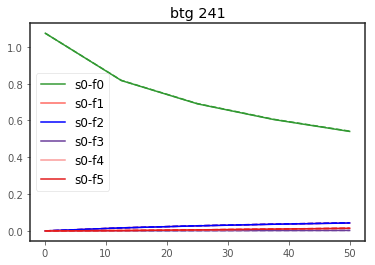

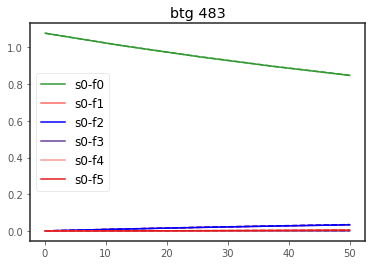

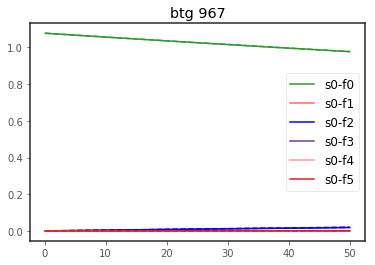

In [136]:
plot_manifold_rates(dtg_high_T_rates, title='dtg')
plot_manifold_rates(btd_high_T_rates, title='btd')
plot_manifold_rates(btg_high_T_rates, title='btg')

6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
10
6000
6000
6000
6000
6000
Calculation complete
s0-manifold 0.35011309572117033
s0-f0 0.2449051851631556
s0-f1 0.005605781576051401
s0-f2 0.010346924808080984
s0-f3 0.0001056695430213092
s0-f4 0.0005170213358850424
s0-f5 0.0004749672051031741
s0-manifold 0.3501537558049667
s0-f0 0.31329118545926476
s0-f1 0.0
s0-f2 0.011046299825144767
s0-f3 0.0002112172387566544
s0-f4 0.0
s0-f5 0.0003069413511287547
s0-manifold 0.3502327955878214
s0-f0 0.33595194950475415
s0-f1 0.0
s0-f2 0.0056531142864274814
s0-f3 5.613166324000489e-05
s0-f4 0.0
s0-f5 7.223420629272012e-05


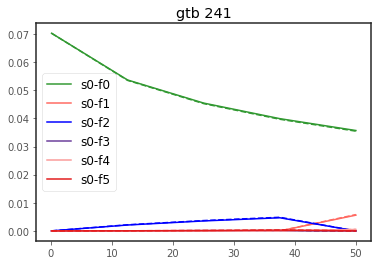

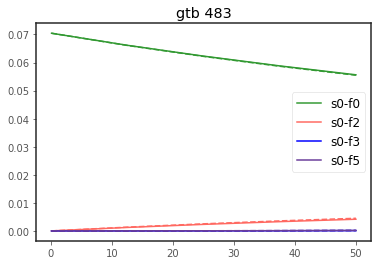

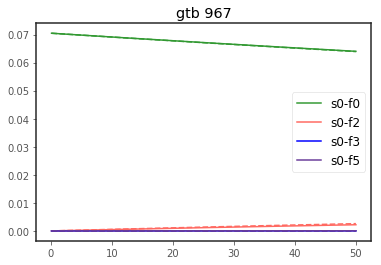

In [140]:
gtb_high_T_rates = lowest_eig_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=6, T_EM=6000,
                                                      start_manifold='ground', end_manifold='bright')
plot_manifold_rates(gtb_high_T_rates, title='gtb')

$\Gamma_{g,+}/\Gamma_{-,0}$

In [ ]:
def plot_population_characterise(dtg_rates, ):
 

# High Temperature characterisation

So, before I looked at:
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$
Now I will check
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$
to see how higher occupation states decay to the dark state.

In [ ]:
def states_to_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5, start_manifold='dark', end_manifold='OO'):
    # This should tell us how the decay scales with phonon temperature. 
    # Also, we can use this to look at decay from bright to dark at low T
    T_EM =0.
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
    couplings = np.linspace(0.1,50,50)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [0,1,2,3,4,5]
    data_dict = {'0-g': copy.deepcopy(in_in_dict), 
               '1-g': copy.deepcopy(in_in_dict),
               '2-g': copy.deepcopy(in_in_dict),
               '3-g': copy.deepcopy(in_in_dict),
                '4-g': copy.deepcopy(in_in_dict),
                '5-g': copy.deepcopy(in_in_dict)}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=N)
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.5)
            ops = make_expectation_operators(PARAMS)
            for idx, state_label in zip(state_indexes ,data_dict.keys()):
                si = states_dict[start_manifold][idx]
                ri = si*si.dag()
                data_dict[state_label]['nonadd'].append(rate_to_manifold(ri, L['nonadd'], 
                                                                         ops, manifold=end_manifold))
                data_dict[state_label]['add'].append(rate_to_manifold(ri, L['add'], 
                                                                         ops, manifold=end_manifold))
            i+=1
            if i%10 == 0:
                print (i)
    print("Calculation complete")
    return data_dict, couplings

In [ ]:
data_dict_77, couplings = exciton_to_ground(150, 150., 150., 77, N=6)
plot_decay_rates(data_dict_77)
#data_dict_300, couplings = exciton_to_ground(150, 150., 150., 300, N=6)
#plot_decay_rates(data_dict_300)

Here we can see a few things immediately about the RC model. 

- $\alpha$ alone does not control the rate between bright and dark states, this is done totally through $\Gamma$ since $\gamma = \Gamma/2\pi\Omega$. This means that the immediate BS$\to$DS rate is zero for this product state. 
- The additive electronic decay rates are independent of phonon-coupling strength, but steadystates seem to be dominated by phonon dissipation

# Vibronic level decay

Would like to look at:
- decay of vibronic states to ground
- decay of excited to ground vibronic states
- decay of bright vibronic states to dark manifold

In [3]:
def dark_fock_to_ground_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5):
    # Currently predicts a product state for the initial condition
    T_EM =0.
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = [ 200.]
    Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [0,1,2,3,4,5,6,7]
    data_dict = {'d00-g': copy.deepcopy(in_in_dict), 
               'd01-g': copy.deepcopy(in_in_dict),
               'd10-g': copy.deepcopy(in_in_dict),
               'd11-g': copy.deepcopy(in_in_dict),
                'd02-g': copy.deepcopy(in_in_dict),
                'd20-g': copy.deepcopy(in_in_dict),
                'd21-g': copy.deepcopy(in_in_dict),
                'd22-g': copy.deepcopy(in_in_dict)}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=0)
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.6)
            ops = make_expectation_operators(PARAMS)
            for idx, state_label in zip(state_indexes ,data_dict.keys()):
                si = states_dict['dark'][idx]
                ri = si*si.dag()
                data_dict[state_label]['nonadd'].append(rate_to_manifold(ri, L['nonadd'], 
                                                                         PARAMS, ops, manifold='OO'))
                data_dict[state_label]['add'].append(rate_to_manifold(ri, L['add'], 
                                                                         PARAMS, ops, manifold='OO'))
            i+=1
            if i%10 == 0:
                print (i)
    print("Calculation complete")
    return data_dict, couplings

In [119]:
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=40,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=0)
print_PARAMS(PARAMS)
energies, states = exciton_states(PARAMS)
X = sigma_x1 + PARAMS['mu']*sigma_x2
print( (X*states[0]))
print( (X*states[1]))
#PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)

energies, states, phonon_occs = separate_states(H[1], PARAMS, trunc=0.8)

w_1=11291.70, w_2=11291.70, V=80.66, bias=0.00, w_xx=22583.40, T_1=150.00, T_2=150.00, w0_1=193.57, w0_2=193.57, T_EM=0.00, alpha_EM=0.05, mu=1.00, dipole_1=1.00, dipole_2=1.00, Gamma_1=387.14, Gamma_2=387.14, parity_flip=0.00, alpha_1=40.00, alpha_2=40.00, N_1=7.00, N_2=7.00, exc=7.00, sys_dim=3.00
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.41421356]
 [0.        ]
 [0.        ]]


In [142]:
len(phonon_occs['bright']), len(phonon_occs['dark'])

(24, 57)

In [27]:
# Code for calculating decay rates from DS/BS to GS (manifold and total)

def monomer_2_to_ground_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5):
    # This should tell us how the decay scales with phonon temperature
    T_EM =0.
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
    couplings = np.linspace(0.1,50,50)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [(0,0),(1,0),(0,1),(1,1),(2,0),(0,2)]
    data_dict = {'m00-g': copy.deepcopy(in_in_dict), 
               'm10-g': copy.deepcopy(in_in_dict),
               'm01-g': copy.deepcopy(in_in_dict),
               'm11-g': copy.deepcopy(in_in_dict),
                'm20-g': copy.deepcopy(in_in_dict),
                'm02-g': copy.deepcopy(in_in_dict)}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=N)
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
            ops = make_expectation_operators(PARAMS)
            for idx, state_label in zip(state_indexes ,data_dict.keys()):
                si = tensor(OX, basis(N, n=idx[0]), basis(N, n=idx[1]))
                #si = states_dict['dark'][idx]
                ri = si*si.dag()
                data_dict[state_label]['nonadd'].append(rate_to_manifold(ri, L['nonadd'], 
                                                                         ops, manifold='OO'))
                data_dict[state_label]['add'].append(rate_to_manifold(ri, L['add'], 
                                                                         ops, manifold='OO'))
            i+=1
            if i%10 == 0:
                print (i)
    print("Calculation complete")
    return data_dict, couplings

        


def dark_to_ground(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5):
    # This should tell us how the decay scales with phonon temperature
    T_EM =0.
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
    couplings = np.linspace(0.1,50,50)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [0,1,2,3,4,5]
    data_dict = {'d0-g0': copy.deepcopy(in_in_dict), 
               'd0-g1': copy.deepcopy(in_in_dict),
               'd0-g2': copy.deepcopy(in_in_dict),
               'd0-g3': copy.deepcopy(in_in_dict),
                'd0-g4': copy.deepcopy(in_in_dict),
                'd0-g5': copy.deepcopy(in_in_dict)}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=N)
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.5)
            ops = make_expectation_operators(PARAMS)
            for idx, state_label in zip(state_indexes ,data_dict.keys()):
                si = states_dict['dark'][0]
                sf = states_dict['ground'][idx]
                ri = si*si.dag()
                rf = sf*sf.dag()
                data_dict[state_label]['nonadd'].append(rate_to_state(ri, rf, L['nonadd']))
                data_dict[state_label]['add'].append(rate_to_state(ri, rf, L['add']))
            i+=1
            if i%10 == 0:
                print (i)
    print("Calculation complete")
    return data_dict, couplings

180.35006272524555 216.42007527029466 0.4472135954999579
10
20
30
40
50
Calculation complete


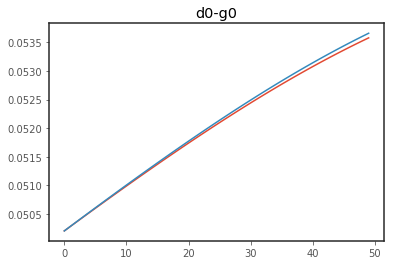

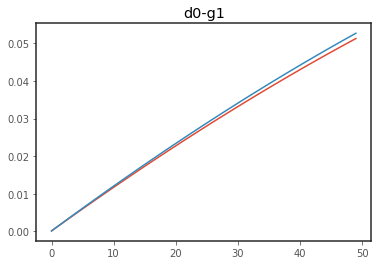

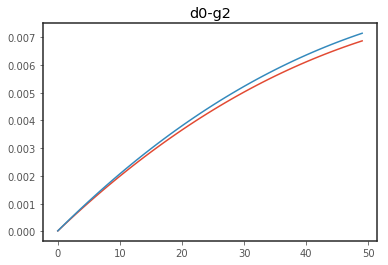

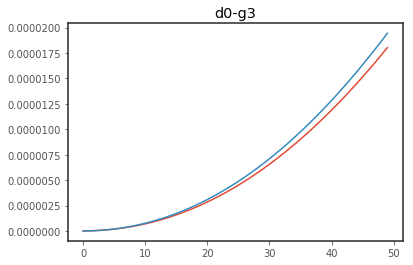

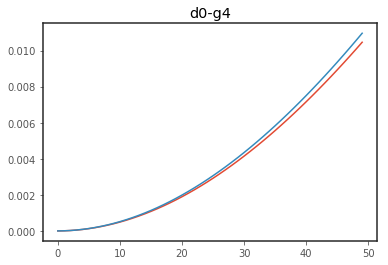

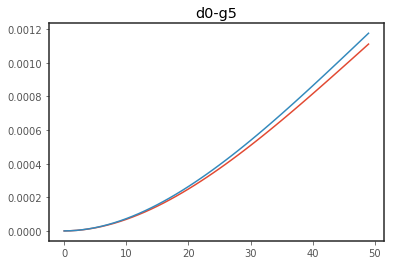

In [5]:
# V=bias

w_2 = 1.4 * ev_to_inv_cm
bias = 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 0.
T_ph = 150
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 2*w0
print (eta, w0, V/eta)
d0tg_manifold_rates, couplings = dark_to_ground(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5)

#m2tg_manifold_rates, couplings = monomer_2_to_ground_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5)

plot_dtg_manifold_rates(d0tg_manifold_rates)

In [28]:
dtg_manifold_rates, couplings = dark_to_ground_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5)
plot_dtg_manifold_rates(dtg_manifold_rates)

10
20
30
40


IndexError: list index out of range

10
20
30
40
50
Calculation complete


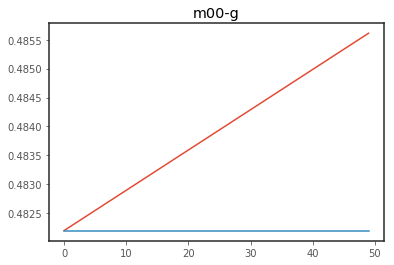

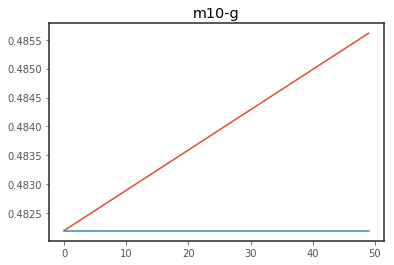

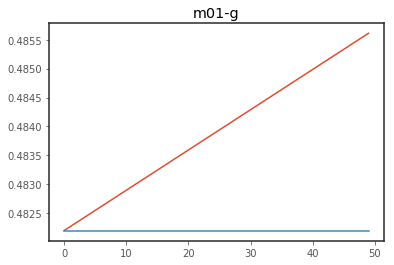

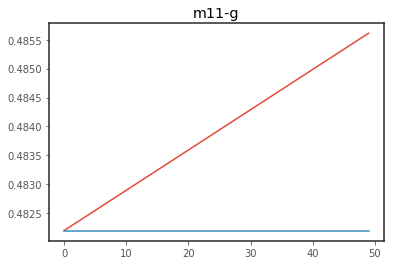

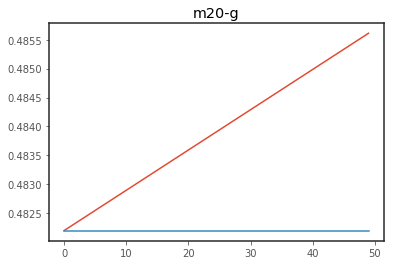

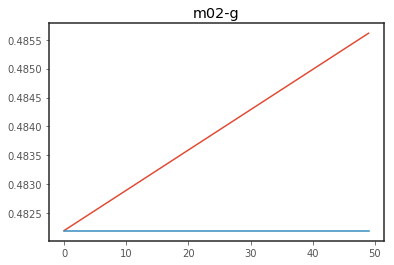

In [11]:
m2tg_manifold_rates, couplings = monomer_2_to_ground_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5)
plot_dtg_manifold_rates(m2tg_manifold_rates)

228.12678974640397 273.75214769568476 0.35355339059327373
10
20
30
40
50
Calculation complete
10
20
30
40
50
Calculation complete
10
20
30
40
50
Calculation complete


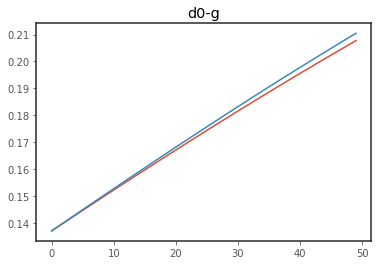

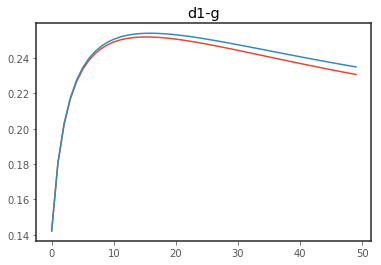

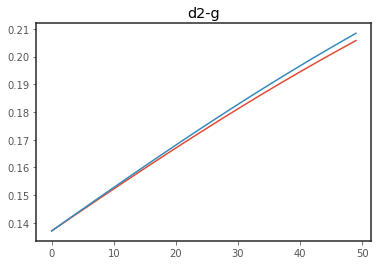

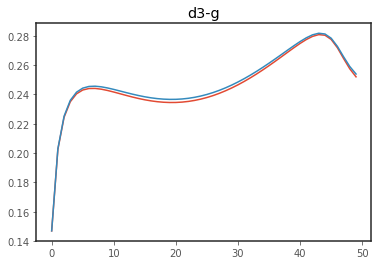

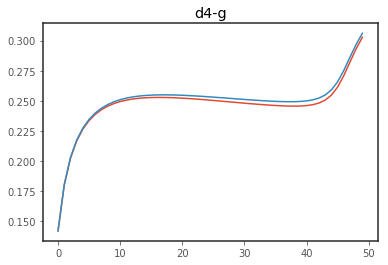

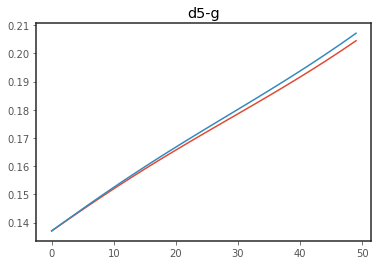

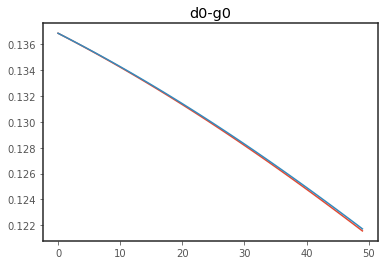

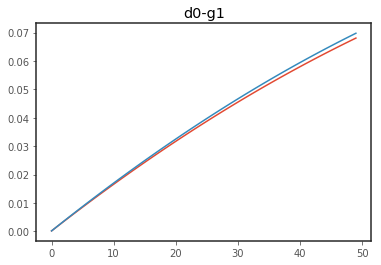

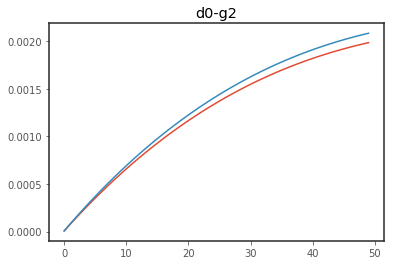

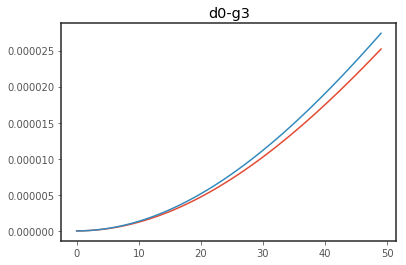

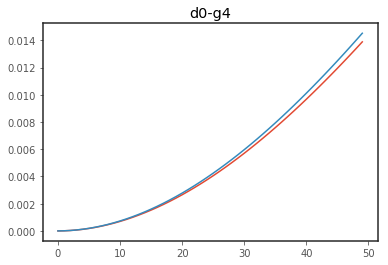

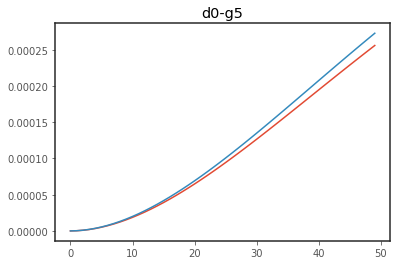

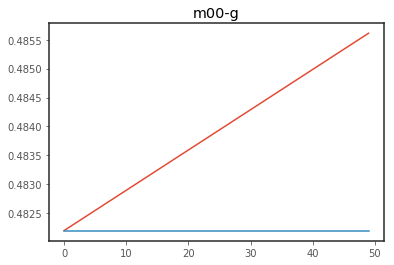

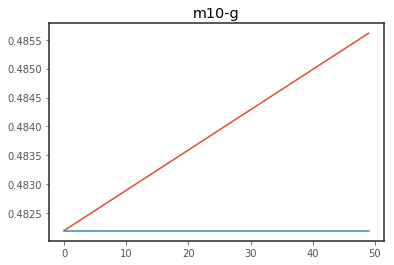

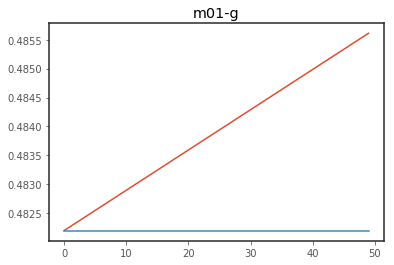

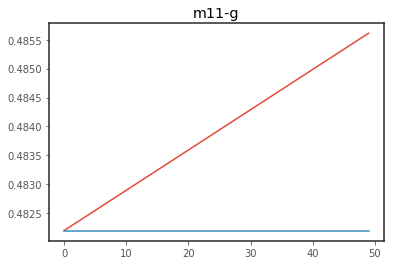

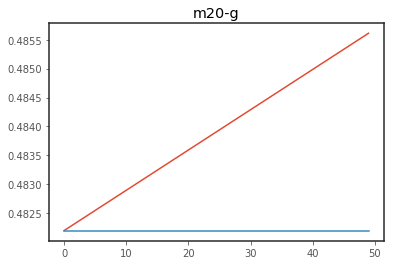

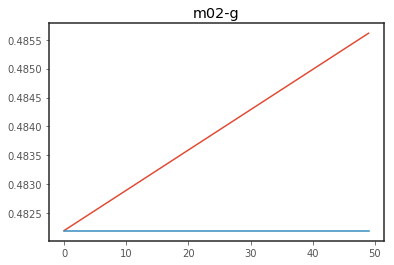

In [18]:
# 2V=bias
w_2 = 1.4 * ev_to_inv_cm
bias = 20e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 0.
T_ph = 150
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 2*w0
print (eta, w0, V/eta)

dtg_manifold_rates_1, couplings = dark_to_ground_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5)
plot_dtg_manifold_rates(dtg_manifold_rates_1)
d0tg_manifold_rates_1, couplings = dark_to_ground(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5)
plot_dtg_manifold_rates(d0tg_manifold_rates_1)
m2tg_manifold_rates, couplings = monomer_2_to_ground_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5)
plot_dtg_manifold_rates(m2tg_manifold_rates)

larger bias enables dark vibronic eigenstates to be used as initial conditions

161.31 193.572 0.5
10
20
30
40
50
Calculation complete
10
20
30
40
50
Calculation complete
10
20
30
40
50
Calculation complete


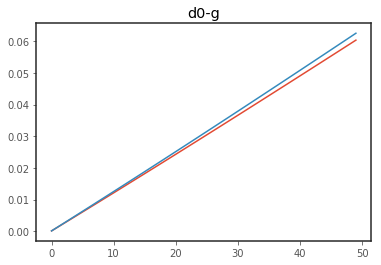

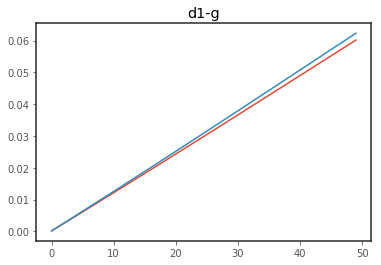

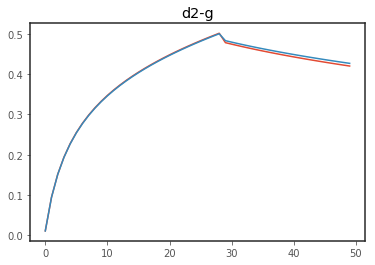

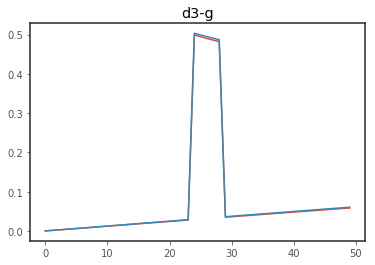

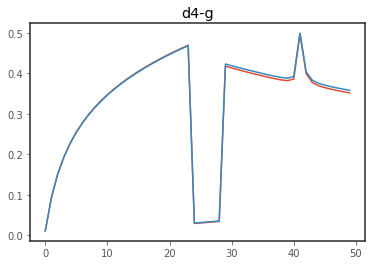

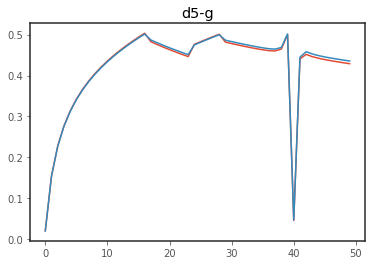

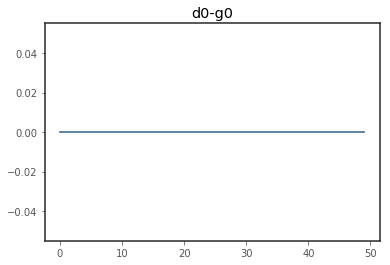

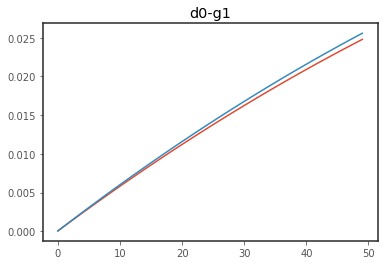

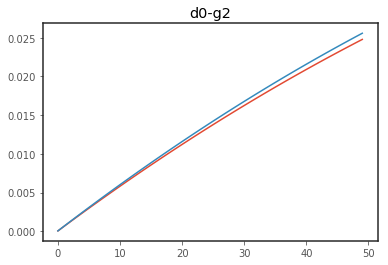

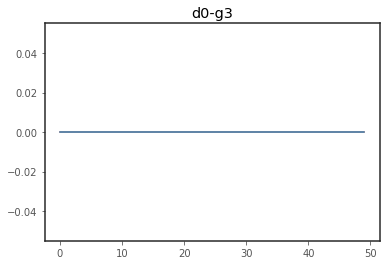

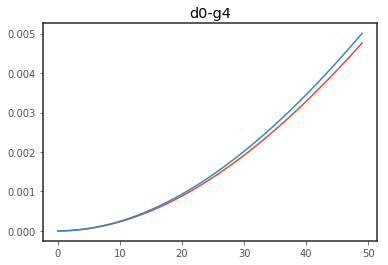

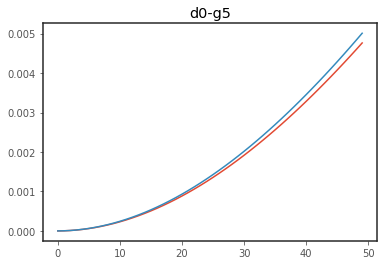

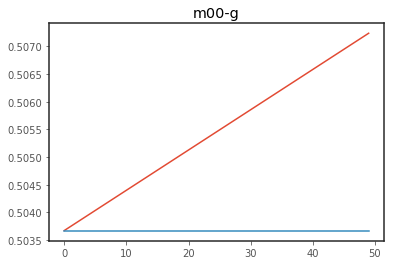

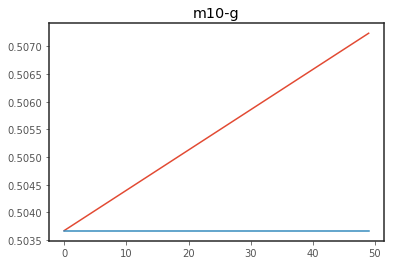

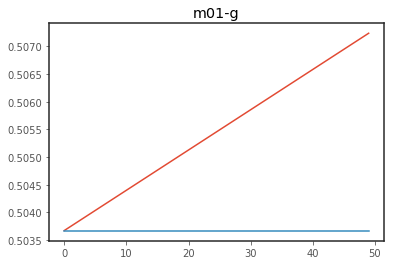

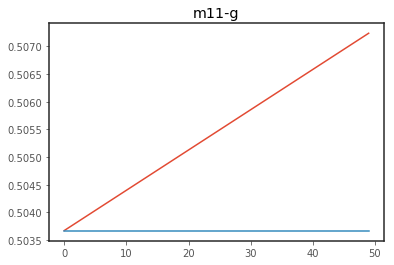

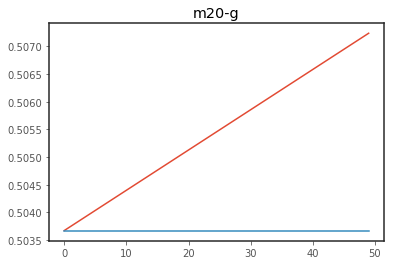

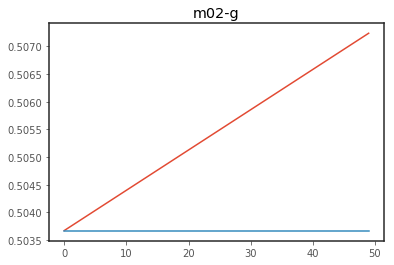

In [19]:
# bias = 0.
w_2 = 1.4 * ev_to_inv_cm
bias = 0. #0e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 0.
T_ph = 150
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 2*w0
print (eta, w0, V/eta)

dtg_manifold_rates_2, couplings = dark_to_ground_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=6)
plot_dtg_manifold_rates(dtg_manifold_rates_2)
d0tg_manifold_rates_2, couplings = dark_to_ground(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5)
plot_dtg_manifold_rates(d0tg_manifold_rates_2)
m2tg_manifold_rates, couplings = monomer_2_to_ground_manifold(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5)
plot_dtg_manifold_rates(m2tg_manifold_rates)

In [25]:
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=10*alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=5, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=5)
#PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.5)


In [ ]:
def dark_manifold_to_ground(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5):
    # This should tell us how the decay scales with phonon temperature
    T_EM =0.
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = [ 200.]
    couplings = np.linspace(0.1,50,60)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [0,1,2,3,4,5]
    data_dict = {'d0-g0': copy.deepcopy(in_in_dict), 
               'd0-g1': copy.deepcopy(in_in_dict),
               'd0-g2': copy.deepcopy(in_in_dict),
               'd1-g3': copy.deepcopy(in_in_dict),
                'd1-g': copy.deepcopy(in_in_dict),
                'd0-g': copy.deepcopy(in_in_dict)}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=0)
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
            ops = make_expectation_operators(PARAMS)
            for idx, state_label in zip(state_indexes ,data_dict.keys()):
                si = states_dict['dark'][idx]
                ri = si*si.dag()
                data_dict[state_label]['nonadd'].append(rate_to_manifold(ri, L['nonadd'], 
                                                                         PARAMS, ops, manifold='OO'))
                data_dict[state_label]['add'].append(rate_to_manifold(ri, L['add'], 
                                                                         PARAMS, ops, manifold='OO'))
            i+=1
            if i%10 == 0:
                print (i)
    print("Calculation complete")
    return data_dict, couplings

In [2]:
"""def displace(offset, a):
    return (offset*(a.dag()) - offset.conjugate()*a).expm()

def undisplaced_initial(init_sys, PARAMS):
    n1 = Occupation(PARAMS['w0_1'], PARAMS['T_1'])
    n2 = Occupation(PARAMS['w0_2'], PARAMS['T_2'])
    return tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], 
                                              [n1, n2]))
def position_ops(PARAMS):
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    return [tensor(I_sys, (a + a.dag())*0.5) for a in atemp] # Should have a 0.5 in this

def displaced_initial(init_sys, PARAMS, silent=False, return_error=False):
    # Works for 
    offset_1 = 0.5*sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    offset_2 = 0.5*sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    x = position_ops(PARAMS)
    
    r0 = undisplaced_initial(init_sys, PARAMS)
    disp = copy.deepcopy(r0)
    for offset, a_ in zip([offset_1, offset_2], atemp):
        d = tensor(I_sys, displace(offset, a_))
        disp =  d * disp * d.dag()
    error = 100*(abs((disp*x[0]).tr()- offset_1)/offset_1 + abs((disp*x[1]).tr()- offset_2)/offset_2)
    if not silent:
        print ("Error in displacement: {:0.8f}%".format(error))
        print ("Ratio of kBT to Omega: {:0.4f}".format(0.695*PARAMS['T_1']/PARAMS['w0_1']))
        if ((PARAMS['T_1'] != PARAMS['T_2']) or (PARAMS['w0_1'] != PARAMS['w0_2'])):
           print("Ratio of kBT to Omega (2): {:0.4f}".format(0.695*PARAMS['T_2']/PARAMS['w0_2']))
    if return_error:   
        return disp, error
    else:
        return disp

def get_converged_N(PARAMS, err_threshold=1e-2, max_N=10):
    for N in range(3,max_N+1):
        PARAMS.update({'N_1':N, 'N_2':N, 'exc':N})
        disp, err = displaced_initial(OO_proj, PARAMS, silent=False, return_error=True)
        if err<err_threshold:
            return N
    print("Error could only converge to {}".format(err))
    return max_N"""
        
# Development and test code for displaced initial states
PARAMS = PARAMS_setup(bias=0, w_2=100, 
                              V = 100., alpha=50.,
                              T_EM=0., T_ph=300., alpha_EM=1, shift=True,
                              num_cpus=4, N=10, Gamma=1, w_0=200,
                              silent=True, exc_diff=0)

#PARAMS['T_2'] = 300.
N1, N2, exc = PARAMS['N_1'], PARAMS['N_2'], PARAMS['exc']

atemp = enr_destroy([N1, N2], exc)

#assert (np.sum(sum(displace(0.1, atemp[0]) - (tensor(qt.displace(N1, 0.1), 
#                                                     qt.identity(N2)))))) ==0 # 

offset_1 = PARAMS['alpha_1']/PARAMS['w0_1']
offset_2 = PARAMS['alpha_2']/PARAMS['w0_2']
x_1 = tensor(I_sys, atemp[0] + atemp[0].dag())*0.5
x_2 = tensor(I_sys, atemp[1] + atemp[1].dag())*0.5

i0 = undisplaced_initial(OO_proj, PARAMS)
#assert ( i0.shape == d1.shape)

assert (abs(i0.tr()-1) < 1e-10) # trace of dm is 1
assert (abs((i0*x_1).tr()) < 1e-10) # initally not displaced
#assert (d1.dag()*d1 == (tensor(qt.identity(3), qt.identity(N1),qt.identity(N2)))) # operator same size
#assert (d2.dag()*d2 == (tensor(qt.identity(3), qt.identity(N1),qt.identity(N2))))


offset_1 = 0.5*sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
offset_2 = 0.5*sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
disp = displaced_initial(OO_proj, PARAMS, silent=False)
ops = make_expectation_operators(PARAMS)
assert abs((disp*ops['OO']).tr() -1)<1e-10
x = position_ops(PARAMS)
print(offset_1,  [(disp*x_).tr() for x_ in x])

Error in displacement: 0.72603745%
Ratio of kBT to Omega: 1.0425
0.31332853432887503 [0.3122532521052312, 0.312128934037432]


In [ ]:
def dark_to_ground_states(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., N=5):
    # Currently predicts a product state for the initial condition
    T_EM =0.
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = [ 200.]
    couplings = np.linspace(0.1,50,60)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [(0,0), (0,1), (0,2), (0,3), (1,0), (2,0), (3,0)]
    data_dict = {'d0-g0': copy.deepcopy(in_in_dict), 
               'd0-g10': copy.deepcopy(in_in_dict),
               'd0-g01': copy.deepcopy(in_in_dict),
               'd0-g11': copy.deepcopy(in_in_dict),
                'd01-g0': copy.deepcopy(in_in_dict),
                'd10-g0': copy.deepcopy(in_in_dict),
                'd11-g0': copy.deepcopy(in_in_dict)}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=0)
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict = separate_states(H[1], PARAMS, trunc=0.8)
            ops = make_expectation_operators(PARAMS)
            for idxs, state_label in zip(state_indexes ,data_dict.keys()):
                ri = states_dict['dark'][idxs[0]]
                rf = states_dict['ground'][idxs[1]]
                data_dict[state_label]['nonadd'].append(rate_general(ri*ri.dag(), rf*rf.dag(), L['nonadd']))
                data_dict[state_label]['add'].append(rate_general(ri*ri.dag(), rf*rf.dag(), L['add']))
            i+=1
            if i%10 == 0:
                print (i)
    print("Calculation complete")
    return data_dict, couplings

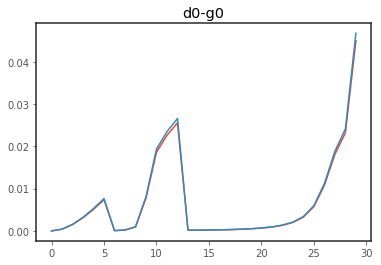

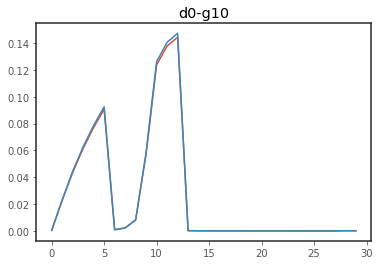

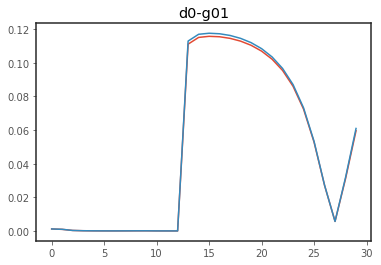

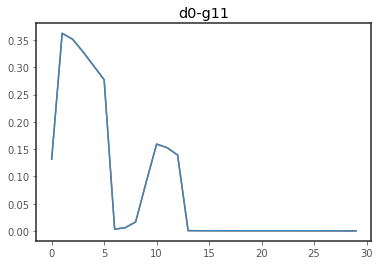

In [53]:
w_2 = 1.4 * ev_to_inv_cm
bias = 1000 #10e-3 * ev_to_inv_cm
V = 0.#82.25228377376521 # 1e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 0.
T_ph = 150
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 2*w0
print (eta, w0, V/eta, Occupation(w0, T_ph))

N=7
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=0)
            
#PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0.)
ops = make_expectation_operators(PARAMS)

1000.0 1200.0 0.0 1.0021464197456252e-05


In [56]:
energies, states, occs = separate_states(H[1], PARAMS, trunc=0.9)

This will not work for V=0. Ground contains all states.


In [57]:
energies['ground']

[0.0,
 1200.0,
 1200.0,
 2400.0,
 2400.0000000000005,
 2400.0000000000005,
 3600.0,
 3600.0,
 3600.0000000000005,
 3600.0000000000005,
 4800.0,
 4800.0,
 4800.0,
 4800.0,
 4800.000000000001,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.000000000001,
 6000.000000000001,
 7199.999999999999,
 7199.999999999999,
 7200.0,
 7200.0,
 7200.0,
 7200.000000000001,
 7200.000000000001,
 8400.0,
 8400.0,
 8400.0,
 8400.0,
 8400.000000000002,
 8400.000000000002,
 11285.36537111312,
 12285.36537111312,
 12485.365371113117,
 12485.365371113221,
 13485.36537111312,
 13485.365371113223,
 13685.365371113132,
 13685.365371113223,
 13685.365371247852,
 14685.365371113132,
 14685.365371113223,
 14685.365371247852,
 14885.36537111959,
 14885.365371151787,
 14885.365371247852,
 14885.365455424366,
 15885.36537111959,
 15885.365371151787,
 15885.36537124785,
 15885.365455424368,
 16085.365373563256,
 16085.365383294764,
 16085.36540745184,
 16085.365455424368,
 16085.388926940122,
 17085.365373563258,
 17085.3653

In [49]:
occs

{'dark': [(0.02100462717316022, 0.021004627173160196),
  (0.5210046249459234, 0.5210046249458645),
  (0.36089317839160523, 0.360893178391673),
  (1.0210043921781917, 1.0210043921783687),
  (0.860892825253464, 0.8608928252533475),
  (0.824567034352385, 0.8245670343522441),
  (1.520993809199481, 1.5209938091993493),
  (1.36087263691391, 1.3608726369142212),
  (1.3245444091028378, 1.3245444091026402),
  (1.3056251965449939, 1.3056251965449936),
  (2.0207675590085517, 2.0207675590085983),
  (1.8605236526777258, 1.8605236526778375),
  (1.8239791630097606, 1.823979163010284),
  (1.8051782899507836, 1.805178289951104),
  (2.2594432795989996, 2.25944327959877),
  (2.51772317405972, 2.5177231740593315),
  (2.3600089605391696, 2.3600089605395658),
  (2.323884389166594, 2.323884389165909),
  (2.304910127889325, 2.3049101278903783),
  (2.292828908886766, 2.2928289088865323),
  (2.7576487387996687, 2.757648738798608),
  (2.9877913081386467, 2.987791308138118),
  (2.8606784973018446, 2.8606784973025

In [28]:
occs

{'dark': [(0.00030185662799921223, 0.12661274719119167),
  (0.14929025342147445, 0.03294788376662086),
  (0.5003121076074428, 0.6266014014445878),
  (0.6558717760758821, 0.5426380338081216),
  (0.6492614587668402, 0.5329687886966818),
  (1.0014185634589103, 1.1254473212806428),
  (1.1556090330916078, 1.0409423630172936),
  (1.1562741825500307, 1.0418713710912475),
  (1.1477642242971429, 1.0341960416357487),
  (1.5368689462138765, 1.5892251930682832),
  (1.5269605177423813, 1.658108542714433),
  (1.689566116415106, 1.5021625914802215),
  (1.735849109945718, 1.455524783029235),
  (1.6524560833062394, 1.5259771254749381),
  (2.2228347888533766, 1.9000581704678825),
  (1.8566296746524626, 2.315979036121622),
  (1.949190724935294, 2.231263846162967),
  (1.497872783829467, 2.673751630534167),
  (1.316654535738885, 2.844721142800131),
  (4.069157531016794, 0.062062687574923205),
  (3.0223176947543706, 2.094587263673971),
  (2.3256011447161344, 2.8351914182184617),
  (2.11381228540308, 3.05334